In [ ]:
# Install required libraries
!pip install pandas openpyxl
!pip install pandas loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Import libraries for data manipulation and visualization
import pandas as pd
from loguru import logger
import seaborn as sns
import matplotlib.pyplot as plt

## Data Import
We start by importing all necessary datasets and libraries.

In [ ]:
df_nav_markets = pd.read_excel('input.xlsx', sheet_name='Mercados Navegando')
df_world_population = pd.read_excel('input.xlsx', sheet_name='Población mundial')
df_users_ww = pd.read_excel('input.xlsx', sheet_name='Usuarios de internet global')
df_arg_revenue_market = pd.read_excel('input.xlsx', sheet_name='Facturación Mercado Argentino')
df_usd_exg_rate = pd.read_excel('input.xlsx', sheet_name='Tipo de cambio USD')
df_arg_market_share = pd.read_excel('input.xlsx', sheet_name='Share de mercado Argentina')
df_arg_internet_access = pd.read_excel('input.xlsx', sheet_name='Acceso a internet en Argentina')
df_ide = pd.read_excel('input.xlsx', sheet_name='IDE', header=2)
df_countries = pd.read_excel('input.xlsx', sheet_name='Países')
df_gdp = pd.read_excel('input.xlsx', sheet_name='GDP', header=1)
df_defaults = pd.read_excel('input.xlsx', sheet_name='Defaults')
df_country_risk = pd.read_excel('input.xlsx', sheet_name='Riesgo país')

In [ ]:
# Map Spanish month names to English month numbers
month_mapping = {
    'Enero': '01', 'Febrero': '02', 'Marzo': '03', 'Abril': '04',
    'Mayo': '05', 'Junio': '06', 'Julio': '07', 'Agosto': '08',
    'Septiembre': '09', 'Octubre': '10', 'Noviembre': '11', 'Diciembre': '12'
}


# Regional Economic and Demographic Analysis

The selected economic and demographic metrics provide essential insights into the telecom market potential across Argentina and other key Latin American countries. Population size and growth indicate market scale and future demand trends, while GDP and GDP per capita reflect economic health and consumer purchasing power. Foreign Direct Investment (FDI) serves as a key signal of investor confidence and capital inflow, helping to gauge the country's attractiveness and stability for international investment.

By comparing these indicators regionally, investors can assess relative market maturity, growth opportunities, and risks. This comprehensive, data-driven analysis supports informed decisions about investing in Argentina's internet sector within the broader Latin American context.

In [ ]:
# List of Latin American countries you want to compare
latam_countries = ['Argentina', 'Brasil', 'Bolivia', 'Chile', 'Paraguay', 'Perú', 'Uruguay']

# Filter only the countries in the list
pop_latam = df_world_population[df_world_population['Country Name'].isin(latam_countries)]

# Transform year columns into rows
pop_latam_long = pop_latam.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name'],
                                 var_name='Year', value_name='Population')

# Convert year to integer
pop_latam_long['Year'] = pop_latam_long['Year'].astype(int)

# Ensure population is numeric
pop_latam_long['Population'] = pd.to_numeric(pop_latam_long['Population'], errors='coerce')

# Sort by country and year
pop_latam_long = pop_latam_long.sort_values(['Country Name', 'Year'])

# Calculate growth by country
pop_latam_long['Growth %'] = pop_latam_long.groupby('Country Name')['Population'].pct_change() * 100

# Population in millions for easier reading in Power BI
pop_latam_long['Population (millions)'] = pop_latam_long['Population'] / 1_000_000


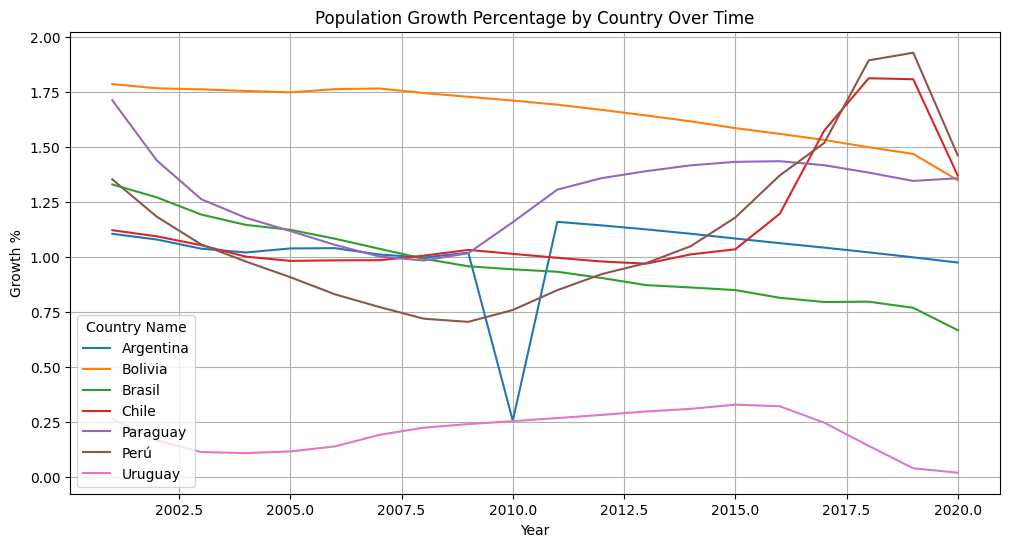

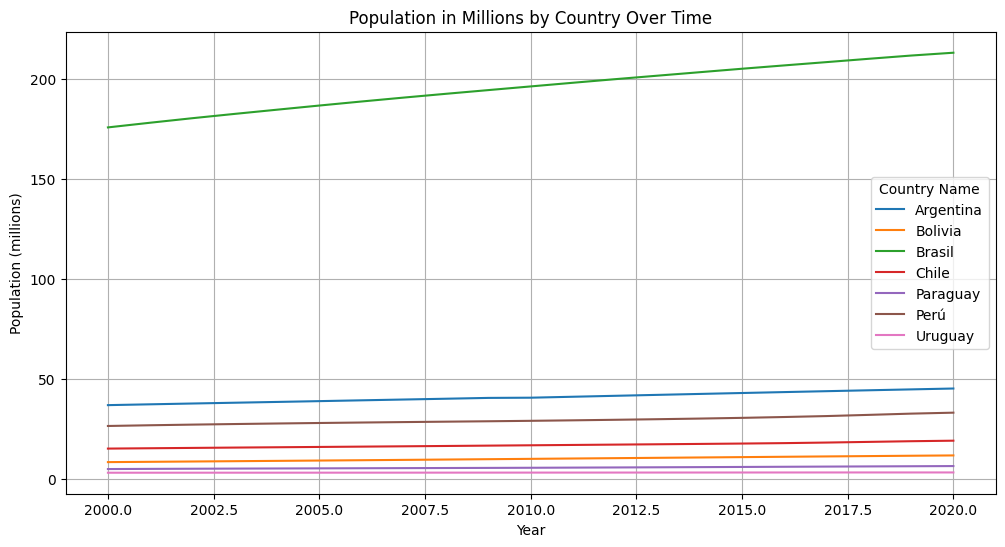

In [ ]:

# Plotting Growth %
plt.figure(figsize=(12, 6))
sns.lineplot(data=pop_latam_long, x='Year', y='Growth %', hue='Country Name')
plt.title('Population Growth Percentage by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Growth %')
plt.grid(True)
plt.show()

# Plotting Population (millions)
plt.figure(figsize=(12, 6))
sns.lineplot(data=pop_latam_long, x='Year', y='Population (millions)', hue='Country Name')
plt.title('Population in Millions by Country Over Time')
plt.xlabel('Year')
plt.ylabel('Population (millions)')
plt.grid(True)
plt.show()


In [ ]:
# Filter only the relevant GDP component (Gross Domestic Product)
gdp_filtered = df_gdp[
    (df_gdp['COMPONENT'] == 'Gross domestic product (GDP)') &
    (df_gdp['ECONOMY'].isin(['Argentina', 'Brazil', 'Bolivia (Plurinational State of)', 'Chile', 'Paraguay', 'Peru', 'Uruguay']))
]

# Standardize country names in the GDP dataset to match those in the population dataset
gdp_filtered['ECONOMY'] = gdp_filtered['ECONOMY'].replace({
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brazil': 'Brasil',
    'Mexico': 'México',
    'Peru': 'Perú'
})


<ipython-input-8-180fa7217432>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_filtered['ECONOMY'] = gdp_filtered['ECONOMY'].replace({


In [ ]:
# Rename columns to ensure compatibility between datasets
gdp_filtered = gdp_filtered.rename(columns={'ECONOMY': 'Country Name', 'YEAR': 'Year', 'GDP': 'GDP (USD)'})
gdp_filtered['Year'] = gdp_filtered['Year'].astype(int)

# Merge GDP data with population data using country and year as keys
merged = pd.merge(pop_latam_long, gdp_filtered, on=['Country Name', 'Year'], how='inner')

# Clean GDP values (remove thousand separators) and ensure numeric type
merged['GDP (USD)'] = merged['GDP (USD)'].str.replace(',', '', regex=False).astype(float)

# Ensure population values are numeric (in millions)
merged['Population (millions)'] = merged['Population (millions)'].astype(float)

# Calculate GDP per capita (in USD)
merged['GDP per Capita (USD)'] = merged['GDP (USD)'] / merged['Population (millions)']


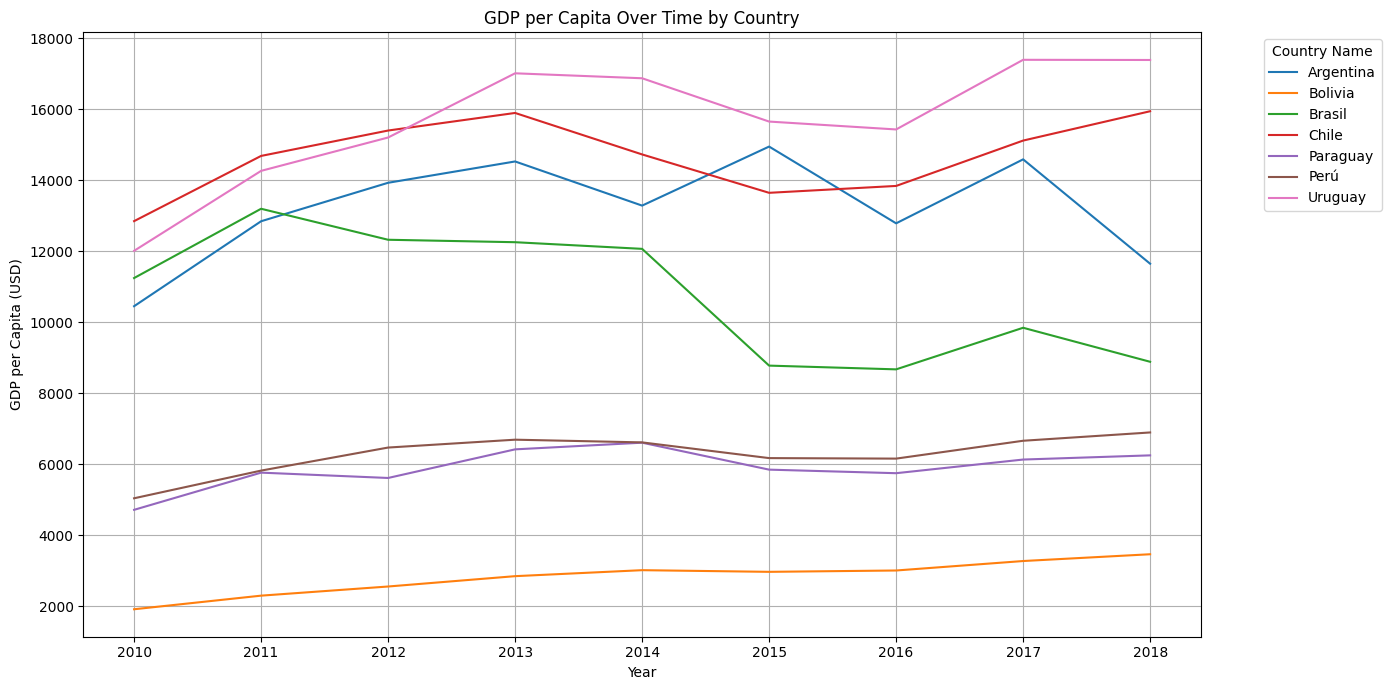

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged, x='Year', y='GDP per Capita (USD)', hue='Country Name')
plt.title('GDP per Capita Over Time by Country')
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.legend(title='Country Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent legend from overlapping
plt.show()

In [ ]:
# Standardize data types
df_ide['Year'] = df_ide['Year'].astype(int)

# Filter only relevant countries
df_ide_filtered = df_ide[
    df_ide['Region/economy'].isin(['Argentina', 'Brazil', 'Bolivia, Plurinational State of', 'Chile', 'Paraguay', 'Peru', 'Uruguay'])
]

# Rename column to align with other datasets
df_ide_filtered = df_ide_filtered.rename(columns={'Region/economy': 'Country Name'})

# Standardize country names to match population and GDP datasets
df_ide_filtered['Country Name'] = df_ide_filtered['Country Name'].replace({
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brazil': 'Brasil',
    'Mexico': 'México',
    'Peru': 'Perú'
})

# Ensure consistent country naming across datasets

# Merge FDI data using a left join to preserve all population-GDP entries
merged_df_fdi = pd.merge(
    merged,
    df_ide_filtered[['Country Name', 'Year', 'Value']],
    on=['Country Name', 'Year'],
    how='left'
)

# Clean FDI values (remove whitespace) and convert to numeric
merged_df_fdi['Value'] = merged_df_fdi['Value'].str.replace(' ', '', regex=False).astype(float)

# Rename column to a more descriptive name
merged_df_fdi = merged_df_fdi.rename(columns={'Value': 'FDI (USD)'})


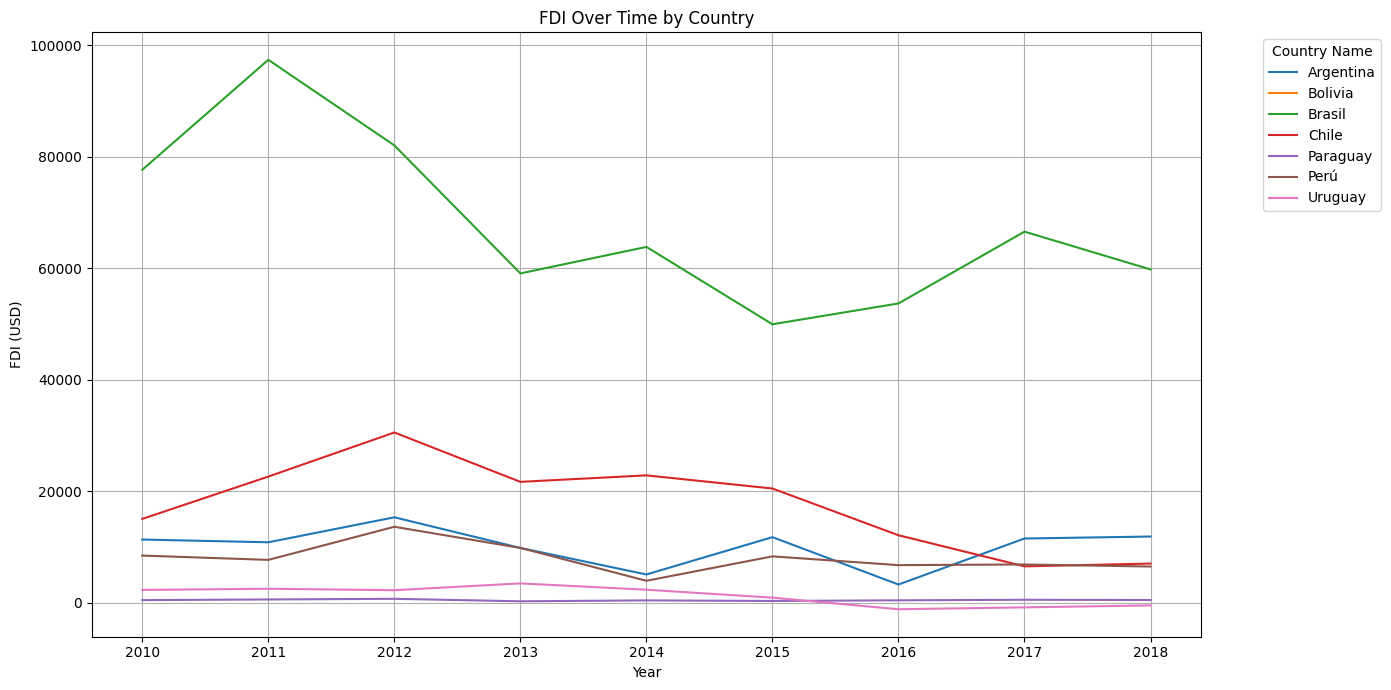

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_df_fdi, x='Year', y='FDI (USD)', hue='Country Name')
plt.title('FDI Over Time by Country')
plt.xlabel('Year')
plt.ylabel('FDI (USD)')
plt.legend(title='Country Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
merged_df_fdi.to_excel('macroeconomic_latam_data.xlsx', index=False)

In [ ]:
merged_df_fdi

,Country Name,Country Code,Indicator Name,Year,Population,Growth %,Population (millions),COMPONENT,GDP (USD),GDP per Capita (USD),FDI (USD)
0,Argentina,ARG,"Población, total",2010,40788453.0,0.255909,40.788453,Gross domestic product (GDP),426487.43,10456.082509,11332.7
1,Argentina,ARG,"Población, total",2011,41261490.0,1.159733,41.261490,Gross domestic product (GDP),530158.18,12848.740557,10839.9
2,Argentina,ARG,"Población, total",2012,41733271.0,1.143393,41.733271,Gross domestic product (GDP),581430.90,13932.071129,15323.9
3,Argentina,ARG,"Población, total",2013,42202935.0,1.125395,42.202935,Gross domestic product (GDP),613316.03,14532.544478,9821.7
4,Argentina,ARG,"Población, total",2014,42669500.0,1.105527,42.669500,Gross domestic product (GDP),567050.15,13289.355394,5065.3
...,...,...,...,...,...,...,...,...,...,...,...
58,Uruguay,URY,"Población, total",2014,3391662.0,0.310010,3.391662,Gross domestic product (GDP),57235.94,16875.484644,2328.0
59,Uruguay,URY,"Población, total",2015,3402818.0,0.328924,3.402818,Gross domestic product (GDP),53274.36,15655.953389,904.6
60,Uruguay,URY,"Población, total",2016,3413766.0,0.321733,3.413766,Gross domestic product (GDP),52687.60,15433.863950,-1176.9
61,Uruguay,URY,"Población, total",2017,3422200.0,0.247059,3.422200,Gross domestic product (GDP),59530.10,17395.272047,-837.3


# Currency Exchange and Country Risk in Argentina

To decide if investing in Argentina is a good idea, it’s important to look at the country’s risk level and how its currency has changed over time.

These two factors can affect how safe and profitable the investment would be.

If the risk is high or the currency loses value, the company could lose money.
That’s why I analyzed the relationship between Argentina’s country risk and the exchange rate to better understand the economic situation.

In [ ]:

df_country_risk['Fecha'] = pd.to_datetime(df_country_risk['Fecha'], dayfirst=False)

# Try to convert 'Riesgo' to float, coercing errors to NaN
df_country_risk['Riesgo'] = pd.to_numeric(df_country_risk['Riesgo'], errors='coerce')

# Drop rows where 'Riesgo' is NaN (could not be converted)
df_country_risk.dropna(subset=['Riesgo'], inplace=True)

risco_arg = df_country_risk[df_country_risk['Pais'] == 'Argentina']

logger.info("Coluna 'Riesgo' transformada para float. Linhas com valores não convertíveis foram removidas.")



2025-06-07 00:33:26.676 | INFO     | __main__:<cell line: 0>:11 - Coluna 'Riesgo' transformada para float. Linhas com valores não convertíveis foram removidas.


In [ ]:
# Create a year-month column from the date
risco_arg['year-month'] = risco_arg['Fecha'].dt.to_period('M').astype(str)

# Group by country and year-month, and calculate the average risk
risco_arg_monthly = risco_arg.groupby(['Pais', 'year-month'], as_index=False)['Riesgo'].mean()

# Sort the data by country and year-month
risco_arg_monthly = risco_arg_monthly.sort_values(['Pais', 'year-month'])


<ipython-input-6-638b389c61e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risco_arg['year-month'] = risco_arg['Fecha'].dt.to_period('M').astype(str)


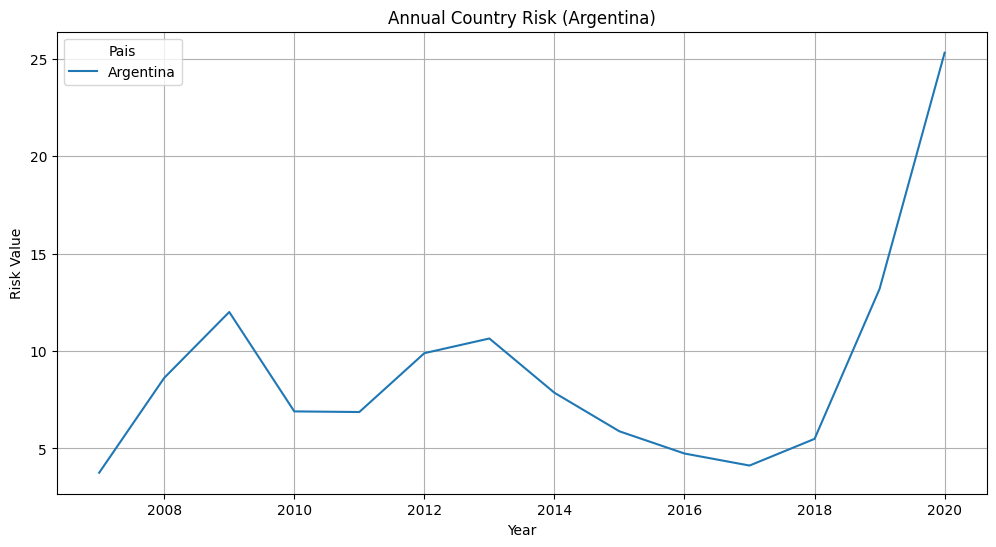

In [ ]:

# Calculate annual risk (e.g., taking the average of monthly risks within a year)
risco_arg_monthly['Year'] = pd.to_datetime(risco_arg_monthly['year-month']).dt.year
risco_arg_annual = risco_arg_monthly.groupby(['Pais', 'Year'], as_index=False)['Riesgo'].mean()

# Plot the annual risk
plt.figure(figsize=(12, 6))
sns.lineplot(data=risco_arg_annual, x='Year', y='Riesgo', hue='Pais')
plt.title('Annual Country Risk (Argentina)')
plt.xlabel('Year')
plt.ylabel('Risk Value')
plt.grid(True)
plt.show()

In [ ]:
# Rename the first column to "Country" (in case it's unnamed or labeled as "VIS-A-VIS ECON.")
df_usd_exg_rate.rename(columns={df_usd_exg_rate.columns[0]: 'Country'}, inplace=True)
df_usd_exg_rate['Country'] = df_usd_exg_rate['Country'].replace({'Argentina (ARS)': 'Argentina'})

# Reshape the dataset to long format
cambio_long = df_usd_exg_rate.melt(id_vars='Country', var_name='Year', value_name='Exchange Rate')

# Convert the 'Year' column to integer type
cambio_long['Year'] = cambio_long['Year'].astype(int)

# Filter for Argentina only
cambio_arg = cambio_long[cambio_long['Country'] == 'Argentina']

# Keep data from the year 2000 onward
cambio_arg = cambio_arg[cambio_arg['Year'] >= 2000]

# Reset index after filtering
cambio_arg = cambio_arg.reset_index(drop=True)


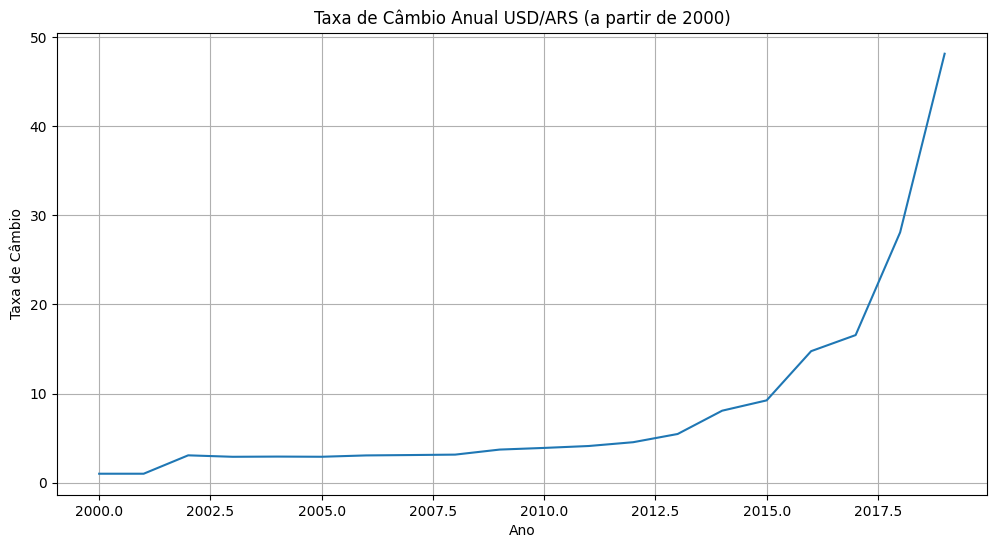

In [ ]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=cambio_arg, x='Year', y='Exchange Rate')
plt.title('Taxa de Câmbio Anual USD/ARS (a partir de 2000)')
plt.xlabel('Ano')
plt.ylabel('Taxa de Câmbio')
plt.grid(True)
plt.show()


In [ ]:
df_macro = pd.merge(risco_arg_monthly, cambio_arg[['Year', 'Exchange Rate']],
                    on='Year', how='inner')

The correlation between the country risk (Riesgo) and the exchange rate (Exchange Rate) is 0.14, which indicates a weak linear relationship between these two variables.

This means that changes in the country risk do not strongly explain the fluctuations in the exchange rate over the analyzed period. Other factors, such as inflation, economic policies, or market expectations, might have a greater impact on the exchange rate in Argentina.

For decision-making, this suggests that country risk alone is not a reliable predictor of exchange rate changes, adding complexity to the investment risk related to currency fluctuations.

In [ ]:
correlation = df_macro[['Riesgo', 'Exchange Rate']].corr(method='pearson').iloc[0,1]
print(f'Correlação entre risco país e câmbio: {correlation:.2f}')

Correlação entre risco país e câmbio: 0.14


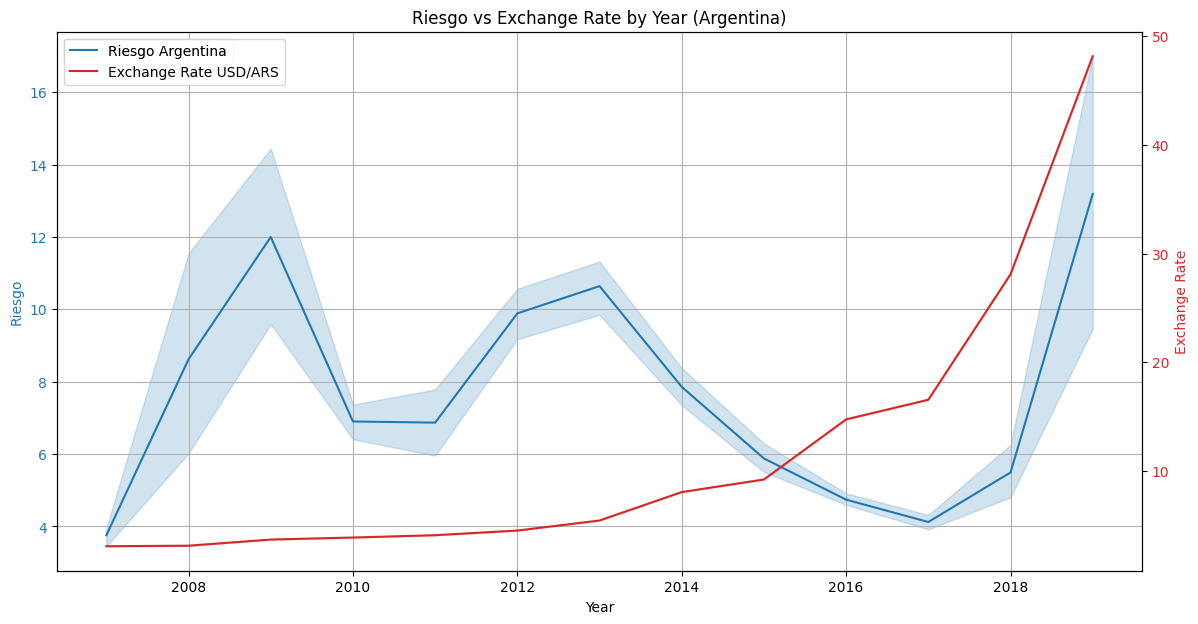

In [ ]:

# Plotting both Riesgo and Exchange Rate on the same chart with separate y-axes

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Riesgo on the first axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Riesgo', color=color)
sns.lineplot(data=df_macro, x='Year', y='Riesgo', ax=ax1, color=color, label='Riesgo Argentina')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Creating the second axis for Exchange Rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Exchange Rate', color=color)
sns.lineplot(data=df_macro, x='Year', y='Exchange Rate', ax=ax2, color=color, label='Exchange Rate USD/ARS')
ax2.tick_params(axis='y', labelcolor=color)

# Add title
plt.title('Riesgo vs Exchange Rate by Year (Argentina)')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0, 1), ncol=1)

plt.show()


In [ ]:
df_macro.head()

,Pais,year-month,Riesgo,Year,Exchange Rate
0,Argentina,2007-10,3.455000,2007,3.095649
1,Argentina,2007-11,3.956471,2007,3.095649
2,Argentina,2007-12,3.858333,2007,3.095649
3,Argentina,2008-01,4.432857,2008,3.144165
4,Argentina,2008-02,4.751579,2008,3.144165


In [ ]:
df_macro.to_excel('risk_and_exchange_arg.xlsx', index=False)

# **Evolution of revenue in USD (Argentina Internet Sector)**

The goal here is to understand Argentina's market for Fixed internet and how its revenue is evolving over time. Before investing in the country, it's crucial to understand how the local market behaves.

In [ ]:
df_arg_revenue_market.head()

,Year,Month,Tipo,Pais,Servicio,Indicador,Valor,Unidad
0,2020,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 15,731",M ARS
1,2020,Marzo,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 13,904",M ARS
2,2019,Diciembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 11,226",M ARS
3,2019,Septiembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 10,066",M ARS
4,2019,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 9,679",M ARS


In [ ]:
df_usd_exg_rate.head()

,Country,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,VIS-A-VIS ECON.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan (AFN),0.044998,0.044998,0.044998,0.044998,0.044998,0.044998,0.044998,0.044998,0.044998,...,46.452461,46.747008,50.9214,55.3775,57.2475,61.143462,67.866086,68.026904,72.083247,77.737949
2,Albania (ALL),5,5,5,5,5,5,5,5,5,...,103.936667,100.895833,108.184167,105.669167,105.48,125.961667,124.1425,119.1,107.989167,109.850833
3,Algeria (DZD),4.93706,4.912638,4.480515,3.962495,4.18075,3.949408,4.163825,4.146758,3.9659,...,74.385983,72.937883,77.535967,79.3684,80.579017,100.691433,109.443067,110.973017,116.593792,119.436508
4,Andorra (EUR),0.420708,0.417515,0.386279,0.35015,0.346703,0.345023,0.402095,0.45654,0.460783,...,0.754309,0.718414,0.778338,0.752945,0.752728,0.901296,0.903421,0.885206,0.846773,0.893276


Understanding a little bit of the dataset, see if there's only the necessary date, in this case, only Argentina revenue in time for the internet business

In [ ]:
# Log unique values for specified columns
for col in ['Servicio', 'Indicador', 'Pais', 'Tipo']:
  unique_values = df_arg_revenue_market[col].unique()
  logger.info(f"Unique values in '{col}': {unique_values}")
# Log range for 'Year' and 'Mes'
for col in ['Year', 'Month']:
  min_value = df_arg_revenue_market[col].min()
  max_value = df_arg_revenue_market[col].max()
  logger.info(f"Range for '{col}': {min_value} - {max_value}")

2025-06-07 00:44:17.295 | INFO     | __main__:<cell line: 0>:4 - Unique values in 'Servicio': ['Acceso a Internet Fija']
2025-06-07 00:44:17.297 | INFO     | __main__:<cell line: 0>:4 - Unique values in 'Indicador': ['Facturación']
2025-06-07 00:44:17.298 | INFO     | __main__:<cell line: 0>:4 - Unique values in 'Pais': ['Argentina']
2025-06-07 00:44:17.299 | INFO     | __main__:<cell line: 0>:4 - Unique values in 'Tipo': ['Información Económica']
2025-06-07 00:44:17.301 | INFO     | __main__:<cell line: 0>:9 - Range for 'Year': 2016 - 2020
2025-06-07 00:44:17.302 | INFO     | __main__:<cell line: 0>:9 - Range for 'Month': Diciembre - Septiembre


In [ ]:
'''
Pivot df_usd_exg_rate so it can be matched with df_arg_revenue_market.
The goal is to analyze the evolution of exchange rates in USD.
'''

# Rename the column to 'country' (assuming the original column is named 'COUNTRY' or similar,
# but here 'YEAR' was renamed, which looks like a mistake; confirm the actual column to rename)
df_usd_exg_rate = df_usd_exg_rate.rename(columns={'COUNTRY_COLUMN_NAME': 'country'})  # replace with actual column name

# Convert dataframe from wide to long format
df_usd_exg_rate_melted = df_usd_exg_rate.melt(id_vars=['country'], var_name='year', value_name='exchange_rate')

# Filter data for Argentina and standardize country name
df_argentina_usd_exg_rate = df_usd_exg_rate_melted[df_usd_exg_rate_melted['country'] == 'Argentina (ARS)'].copy()
df_argentina_usd_exg_rate['country'] = df_argentina_usd_exg_rate['country'].replace('Argentina (ARS)', 'Argentina')


In [ ]:
# Merge revenue data with Argentina's USD exchange rate based on year and country
df_merged = pd.merge(df_arg_revenue_market, df_argentina_usd_exg_rate[['year', 'country', 'exchange_rate']],
                    left_on=['Year', 'Pais'], right_on=['year', 'country'],
                    how='left')

# Remove duplicated columns from the right dataframe after merge
df_merged = df_merged.drop(columns=['year', 'country'])

# Preview the first rows of the merged dataframe
df_merged.head()


,Year,Month,Tipo,Pais,Servicio,Indicador,Valor,Unidad,exchange_rate
0,2020,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 15,731",M ARS,NaN
1,2020,Marzo,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 13,904",M ARS,NaN
2,2019,Diciembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 11,226",M ARS,48.147892
3,2019,Septiembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 10,066",M ARS,48.147892
4,2019,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,"$ 9,679",M ARS,48.147892


Since there's no data for dollar exchange rate for 2020 according to this source: https://www.exchange-rates.org/exchange-rate-history/usd-ars-2020 the avarage value at that year was 	69.86, so I'll use it in this analysis

In [ ]:
df_merged.loc[df_merged['Year'] == 2020, 'exchange_rate'] = 69.86

In [ ]:
'''
Cleaned the 'Valor' column to convert it to float, enabling revenue calculations over time in USD.
'''
df_merged['Valor'] = df_merged['Valor'].astype(str).str.replace('$', '').str.replace(' ', '').str.replace(',', '.', regex=False)
df_merged['Valor'] = pd.to_numeric(df_merged['Valor'])

df_merged['exchange_rate'] = pd.to_numeric(df_merged['exchange_rate'])

# Calculate revenue in USD by dividing local currency value by the exchange rate
df_merged['valor_usd'] = df_merged['Valor'] / df_merged['exchange_rate']


In [ ]:
# Apply the mapping and create the 'year-month' column
df_merged['month_number'] = df_merged['Month'].map(month_mapping)
df_merged['year-month'] = df_merged['Year'].astype(str) + '-' + df_merged['month_number']

# Optional: Convert the 'year-month' column to datetime objects
df_merged['year-month'] = pd.to_datetime(df_merged['year-month'], format='%Y-%m')

# Drop the temporary 'month_number' column
df_merged = df_merged.drop(columns=['month_number'])

df_merged.head()

,Year,Month,Tipo,Pais,Servicio,Indicador,Valor,Unidad,exchange_rate,valor_usd,year-month
0,2020,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,15.731,M ARS,69.860000,0.225179,2020-06-01
1,2020,Marzo,Información Económica,Argentina,Acceso a Internet Fija,Facturación,13.904,M ARS,69.860000,0.199027,2020-03-01
2,2019,Diciembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,11.226,M ARS,48.147892,0.233157,2019-12-01
3,2019,Septiembre,Información Económica,Argentina,Acceso a Internet Fija,Facturación,10.066,M ARS,48.147892,0.209064,2019-09-01
4,2019,Junio,Información Económica,Argentina,Acceso a Internet Fija,Facturación,9.679,M ARS,48.147892,0.201026,2019-06-01


In [ ]:
df_merged.to_excel('argentina revenue evolution for internet.xlsx', index=False)

Internet market revenue in Argentina grew until 2017, but then dropped until 2019, with a small recovery in 2020. This decline might be related to local economic issues and peso devaluation.

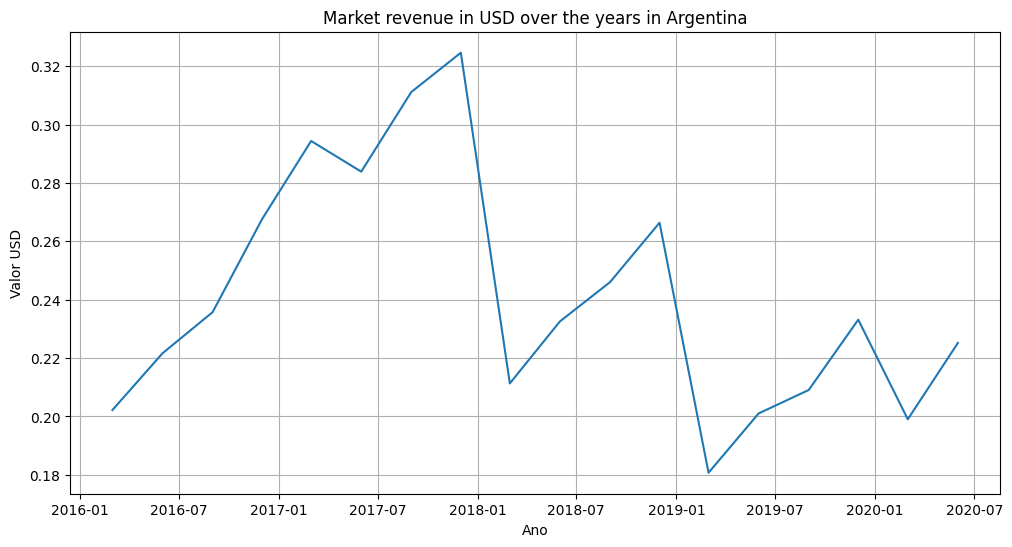

In [ ]:


df_merged['Year'] = df_merged['Year'].astype(int)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_merged, x='year-month', y='valor_usd')
plt.title('Market revenue in USD over the years in Argentina')
plt.xlabel('Ano')
plt.ylabel('Valor USD')
plt.grid(True)
plt.show()


# **Market Share in Argentina**

Understanding market share tells us who the main players are in the internet sector in Argentina and how much control each one has. A market with only one or two dominant companies may mean low competition, which can make it harder for a new company to succeed.

In [ ]:
df_arg_market_share

,Year,Month,Pais,Servicio,Competidor,Share Mercado
0,2020,Junio,Argentina,Empresas,Empresa 1,0.46
1,2020,Junio,Argentina,Empresas,Empresa 2,0.17
2,2020,Junio,Argentina,Empresas,Empresa 3,0.12
3,2020,Junio,Argentina,Empresas,Empresa 4,0.06
4,2020,Junio,Argentina,Empresas,Otros,0.19


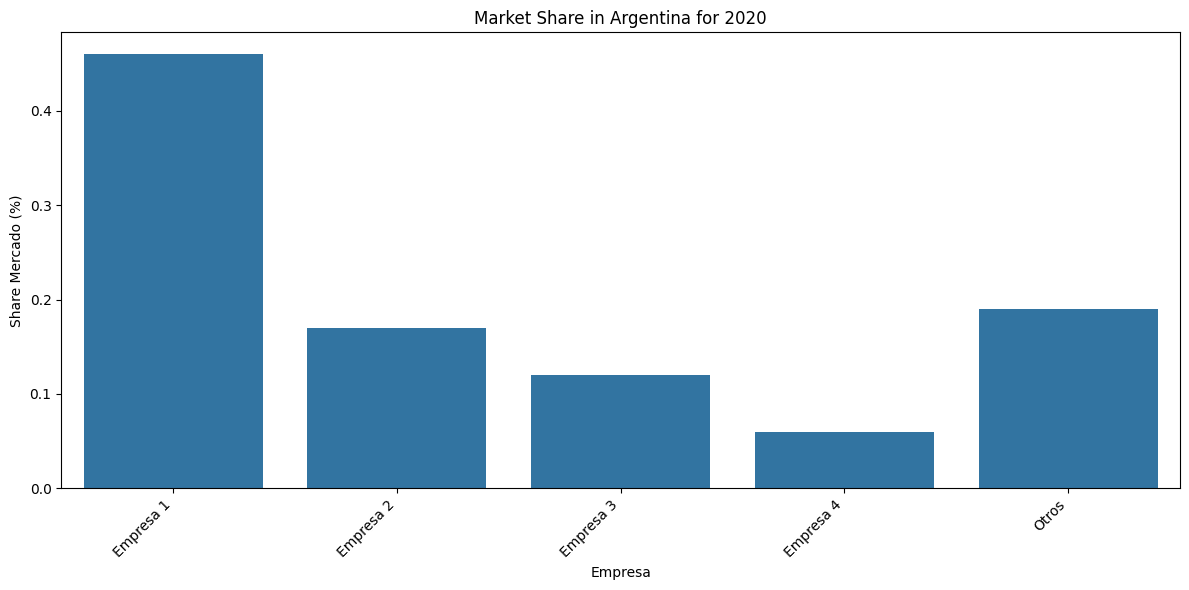

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_arg_market_share, x='Competidor', y='Share Mercado')
plt.title('Market Share in Argentina for 2020')
plt.xlabel('Empresa')
plt.ylabel('Share Mercado (%)')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

### Herfindahl-Hirschman Index (HHI)

source:https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index


The Herfindahl-Hirschman Index (HHI) is a way to measure how competitive or concentrated a market is. It is calculated by summing the squares of each company's market share expressed as a decimal.

- If the HHI is close to 0, the market is very competitive, with many companies holding small shares.
- If the HHI is closer to 1 (or 10,000 if percentages are squared), it means the market is dominated by a few companies, showing high concentration.

In our context, analyzing the HHI for the Argentine internet market helps us understand if the market is competitive or controlled by few players. This is important because a highly concentrated market may indicate risks like lack of competition.


The HHI value is 0.2946, showing that the Argentine internet market is quite concentrated. For example, Company 1 holds 46% of the market, Company 2 has 17%, Company 3 has 12%, Company 4 has 6%, and the rest share 19%. This means a few companies control most of the market, making it harder for new players to compete. This is important to consider when deciding to invest in this market.


In [ ]:
hhi = (df_arg_market_share['Share Mercado'] ** 2).sum()

logger.info(f"HHI = {hhi:.4f}")

2025-06-07 00:46:54.391 | INFO     | __main__:<cell line: 0>:3 - HHI = 0.2946


In [ ]:
df_arg_market_share['HHI'] = hhi

In [ ]:
df_arg_market_share.head()

,Year,Month,Pais,Servicio,Competidor,Share Mercado,HHI
0,2020,Junio,Argentina,Empresas,Empresa 1,0.46,0.2946
1,2020,Junio,Argentina,Empresas,Empresa 2,0.17,0.2946
2,2020,Junio,Argentina,Empresas,Empresa 3,0.12,0.2946
3,2020,Junio,Argentina,Empresas,Empresa 4,0.06,0.2946
4,2020,Junio,Argentina,Empresas,Otros,0.19,0.2946


In [ ]:
df_arg_market_share.to_excel('argentina market Share.xlsx', index=False)

# Evolution of Internet Access, Speed and Revenue in Argentina (2016–2020)

Looking at % of households with internet, average download speed, and revenue in USD helps understand how the service evolved in Argentina. This shows how access and quality improved over time, and how that relates to market growth.

In [ ]:
key_indexs = ['% de hogares con Internet', 'Facturación', 'Velocidad Media de Descarga']

# Filter the dataframe to keep only the key indicators and rows with non-null 'Unidad'
df_filtered = df_arg_internet_access[df_arg_internet_access['Indicador'].isin(key_indexs)].copy()
df_filtered = df_filtered[df_filtered['Unidad'].notna()].copy()
# Alternative query method commented out: df_filtered.query('Unidad != None')

# Map month names to month numbers and create a 'year-month' column
df_filtered['month_number'] = df_filtered['Month'].map(month_mapping)
df_filtered['year-month'] = df_filtered['Year'].astype(str) + '-' + df_filtered['month_number']

# Clean 'Valor' column: remove '$', replace commas with dots, remove '%', then convert to float
df_filtered['Valor'] = (
    df_filtered['Valor']
    .astype(str)
    .str.replace('$', '', regex=False)
    .str.replace(',', '.', regex=False)
    .str.replace('%', '', regex=False)
    .astype(float)
)


In [ ]:
# Merge filtered internet access data with Argentina's USD exchange rate by year
df_merged = pd.merge(df_filtered, df_argentina_usd_exg_rate[['year', 'exchange_rate']],
                     left_on=['Year'], right_on=['year'],
                     how='left')

# Remove duplicated 'year' column from the merged dataframe
df_merged = df_merged.drop(columns=['year'])

# Manually set the exchange rate for the year 2020
df_merged.loc[df_merged['Year'] == 2020, 'exchange_rate'] = 69.86

# Convert exchange rate to numeric type
df_merged['exchange_rate'] = pd.to_numeric(df_merged['exchange_rate'])

# Calculate the value in USD by dividing local currency 'Valor' by the exchange rate
df_merged['valor_usd'] = df_merged['Valor'] / df_merged['exchange_rate']


In [ ]:
# for the case of Faturación converts to USD
df_merged.loc[df_merged['Indicador'] == 'Facturación', 'Valor'] = df_merged['valor_usd']

In [ ]:
# Create a pivot table with 'year-month' as index and indicators as columns, using 'Valor' as values
df_pivot = df_merged.pivot_table(index=['year-month'], columns='Indicador', values='Valor').reset_index()

# Remove the columns' name to clean up the dataframe
df_pivot.columns.name = None

# Rename columns for better readability and consistency
df_pivot = df_pivot.rename(columns={
    '% de hogares con Internet': 'percent_households_internet',
    'Facturación': 'revenue_usd',
    'Velocidad Media de Descarga': 'average_speed_mbps'
})

# Convert 'year-month' column to datetime format
df_pivot['year-month'] = pd.to_datetime(df_pivot['year-month'], format='%Y-%m')


### Evolution of Internet Access in Argentina

This chart shows the evolution of three key internet indicators in Argentina from 2016 to 2020:

- **% of households with internet**: There was a consistent and gradual increase from about 49.5% in early 2016 to nearly 59% by early 2020. This indicates a steady growth in internet adoption across households.

- **Average download speed (Mbps)**: The speed increased significantly, from just 3.6 Mbps in 2016 to over 13 Mbps by 2020. This suggests a strong improvement in service quality over the years.

- **Internet revenue in USD**: The revenue in USD shows some fluctuation. It peaked in late 2017, then dropped in 2018, likely due to macroeconomic factors such as currency devaluation. After that, it remained relatively flat with minor variations.

Overall, the data shows that while internet access and speed improved steadily, revenue in USD did not follow the same upward trend, possibly reflecting economic instability rather than sectoral decline.


Since both access and speed went up, but revenue in USD stayed flat, this might reflect economic instability, not a problem with internet demand. So, based on this data, it could still be a good idea to invest in Argentina — especially in better, faster internet like fiber or high-speed wireless, where demand seems to be growing.


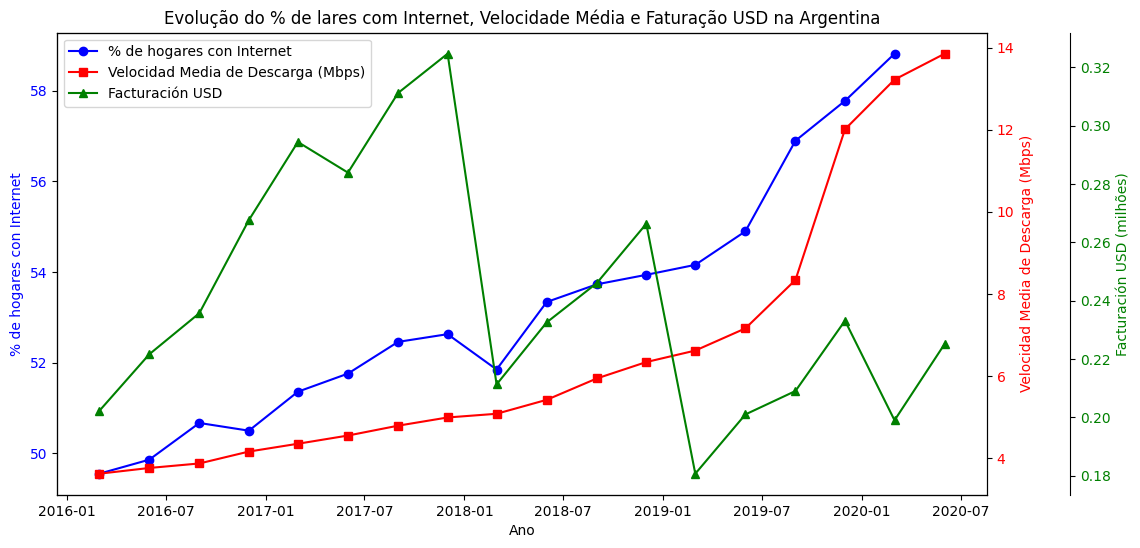

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Linha azul - % de hogares con Internet
line1, = ax1.plot(df_pivot['year-month'], df_pivot['percent_lares_internet'], marker='o', color='blue', label='% de hogares con Internet')
ax1.set_ylabel('% de hogares con Internet', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Segundo eixo Y - Velocidade média de download (vermelho)
ax2 = ax1.twinx()
line2, = ax2.plot(df_pivot['year-month'], df_pivot['velocidade_media_mbps'], marker='s', color='red', label='Velocidad Media de Descarga (Mbps)')
ax2.set_ylabel('Velocidad Media de Descarga (Mbps)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Terceiro eixo Y - Faturação em USD (verde)
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
line3, = ax3.plot(df_pivot['year-month'], df_pivot['faturacao_usd'], marker='^', color='green', label='Facturación USD')
ax3.set_ylabel('Facturación USD (milhões)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

plt.title('Evolução do % de lares com Internet, Velocidade Média e Faturação USD na Argentina')
ax1.set_xlabel('Ano')

# Monta a legenda corretamente, com os três objetos
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()


In [ ]:

df_pivot['year-month'] = df_pivot['year-month'].dt.year.astype(int)
df_pivot = df_pivot.rename(columns={'year-month': 'Year'})

In [ ]:
df_pivot.head()

,Year,percent_lares_internet,faturacao_usd,velocidade_media_mbps
0,2016,49.55,0.202193,3.62
1,2016,49.86,0.221640,3.76
2,2016,50.67,0.235734,3.87
3,2016,50.50,0.267648,4.16
4,2017,51.36,0.294396,4.35


In [ ]:
df_pivot.to_excel('argentina internet access.xlsx', index=False)